### Libraries

In [2]:
import sys
sys.path.insert(0,'/Users/jarad/Fake Folder/Python Libraries')

from jb_libraries import *
%matplotlib inline

### Script settings

In [190]:
date_end = '2018-11-30'
date_start = str((pd.to_datetime(date_end) - pd.DateOffset(months = 5)).date())[:7] + '-01'

image_path = '/Users/jarad/Fake Folder/Shipping/Ad Hoc/UPS 2019 Rate Increase Analysis/Images/'

print('The data begins on {} and ends on {}'.format(date_start, date_end))

The data begins on 2018-06-01 and ends on 2018-11-30


### Resources

[UPS Rate Change Information](https://www.ups.com/us/en/shipping/rates-update.page)

[2019 UPS® Package Accessorial Changes](https://www.ups.com/assets/resources/media/en_US/2019-UPS-Accessorial-Package-Rate-Change.pdf)

### Get data

In [4]:
ups_main = pd.read_sql(
'''
SELECT
*
FROM ups_billing
WHERE DATE(transaction_date) BETWEEN ' '''+ date_start +''' ' AND ' '''+ date_end +''' '
''', db)

col_fix(ups_main)

ups_main['transaction date'] = pd.to_datetime(ups_main['transaction date'])
ups_main['year and month'] = jb_dates(ups_main['transaction date'], 'year and month')

ups_main['year and week'] = ups_main['transaction date'].dt.year.map(str) + '-' + ups_main['transaction date'].dt.week.map(str)
ups_main['week ending'] = ups_main['transaction date'].groupby(ups_main['year and week']).transform('max')
ups_main.drop(['year and week'], 1, inplace = True)

ups_main['charge description'] = [x.lower() for x in ups_main['charge description']]

In [5]:
pd.read_sql('''select * from orders_status order by orders_status_id''', db)

,orders_status_id,language_id,orders_status_name
0,1,1,Pending
1,2,1,Processing
2,3,1,Shipped
3,4,1,Update
4,5,1,Printed
5,6,1,Billed
6,7,1,Payment Received
7,8,1,Fraud - Pending
8,9,1,Fraud - Confirmed
9,10,1,Return


In [6]:
orders_main = pd.read_sql(
'''
SELECT
DATE(date_purchased) AS date_purchased,
o.orders_id,
LOWER(delivery_country) AS delivery_country,
LOWER(orders_status_name) AS orders_status_name,
value AS order_subtotal

FROM orders o

JOIN orders_status os ON o.orders_status = os.orders_status_id

JOIN orders_total ot ON o.orders_id = ot.orders_id
AND class = 'ot_subtotal'

WHERE shipping_module_code = 'upsxml'
''', db)

col_fix(orders_main)

orders_main['date purchased'] = pd.to_datetime(orders_main['date purchased'])
orders_main['delivery country'] = orders_main['delivery country'].str.strip()

### Check to make sure each UPS tracking has at most one OID

In [7]:
c = ups_main.groupby('tracking')[['orders id']].nunique()
if c[c['orders id'] > 1].empty:
    print('TRUE')
else:
    raise 0

TRUE


### Structure

In [8]:
cols = orders_main.columns.tolist()
cols.remove('orders id')

for c in cols:
    ups_main[c] = ups_main['orders id'].map(dict(zip(orders_main['orders id'], orders_main[c])))

### Get days between purchased and shipped

In [9]:
ups_main['days elapsed'] = (ups_main['transaction date'] - ups_main['date purchased']).dt.days

In [10]:
days = ups_main.copy()
days.drop_duplicates('tracking', inplace = True)

des = days['days elapsed'].describe(percentiles = np.arange(0,1.005,0.005))
des.tail()

98.5%      22.00
99%        24.00
99.5%      47.82
100%     2740.00
max      2740.00
Name: days elapsed, dtype: float64

In [11]:
p = des.loc['99.5%']
cols = ['orders id',
        'tracking',
        'date purchased',
        'transaction date',
        'days elapsed']

a = days[days['days elapsed'] > p][cols]
a.sort_values('days elapsed', ascending = False, inplace = True)

In [12]:
a.head()

,orders id,tracking,date purchased,transaction date,days elapsed
20867,73928,1Z5674320307275706,2010-12-18,2018-06-19,2740.0
137947,751089,1Z71EY056693654975,2015-04-01,2018-09-27,1275.0
100655,1570452,1Z71EY050392472291,2017-10-18,2018-08-16,302.0
169446,1632400,1Z71EY054293775853,2017-12-19,2018-10-04,289.0
191726,1647735,1Z71EY054292646860,2018-01-10,2018-10-23,286.0


These types of transactions only account for 0.5% of total transaction count

Assume this stems from a db bug a while back that has already been addressed

Remove these tracking numbers

In [13]:
ups_main.drop(ups_main[ups_main['tracking'].isin(a['tracking'].tolist())].index, inplace = True)
ups_main.reset_index(drop = True, inplace = True)

# Begin analysis

In [94]:
before = ups_main.groupby('year and month')[['netAmount']].sum()
before.columns = ['net amount before rate change']

charge_ls = sorted(list(set(ups_main['charge description'])))

results_dict = {}

### The rates for UPS® Ground, UPS Air and International services will increase an average net 4.9%.
The data below includes both inbound and outbound, but excludes third party billing

In [95]:
ls = ['ground',
     'air']
tracking = list(set(ups_main[(ups_main['charge description'].str.contains('|'.join(ls)))
                 | (ups_main['delivery country'] != 'united states')]['tracking']))

a = ups_main[ups_main['tracking'].isin(tracking)].copy()

increase = 0.049

g1 = a.groupby('year and month').agg({'netAmount':'sum','tracking':'nunique'})
g1.rename(columns = {'netAmount':'original net amount',
                    'tracking':'unique tracking count'}, inplace = True)

g1['increase'] = g1['original net amount'] * increase

t = ups_main.groupby('year and month')[['tracking']].nunique()
g1['tracking as % of total'] = g1[['unique tracking count']].div(t.values)

results_dict['main'] = g1

fmt = ['m0','n0','m0','p2']
display(g1.format_(fmt))

,Original Net Amount,Unique Tracking Count,Increase,Tracking As % Of Total
year and month,,,,
2018-06,"$168,991","11,295","$8,281",97.68%
2018-07,"$189,794","15,296","$9,300",97.82%
2018-08,"$161,828","12,371","$7,930",97.13%
2018-09,"$161,372","12,853","$7,907",97.88%
2018-10,"$190,386","14,683","$9,329",97.44%
2018-11,"$177,499","13,663","$8,697",97.25%


In [96]:
print('charge descriptions not included in the above:')
sorted(list(set(ups_main[~ups_main['tracking'].isin(tracking)]['charge description'])))

charge descriptions not included in the above:


['3 day select commercial',
 '3 day select residential',
 '3 day select return to sender',
 '3 day select undeliverable return',
 'address correction 3 day select',
 'delivery area surcharge',
 'delivery area surcharge - extended',
 'delivery confirmation signature',
 'delivery confirmation signature - commercial',
 'fuel surcharge',
 'residential surcharge',
 'return to sender - web request',
 'shipping charge correction 3 day select',
 'shipping charge correction fuel surcharge']

### Fuel surcharges will apply to Additional Handling, Over Maximum Limits, Signature Required and Adult Signature Required accessorials.

Counts are low; not applicable

In [97]:
do_this = 'no'

if do_this == 'yes':
    ls = ['addl. handling weight',
         'over max limit', # not applicable
         'signature reuired', # not applicable
         'adult signature required']

    display(ups_main[ups_main['charge description'].isin(ls)].groupby(['year and month','charge description'])[['charge description']].count())

### A processing fee of \\$2.00 per package will be charged when Package Level Detail (PLD) is not provided to UPS prior to delivery.

We always do this; not applicable

### Domestic Air Fuel Surcharge
Effective December 31, 2018, the Domestic Air Fuel Surcharge will increase by 0.25% for all thresholds. These surcharges will continue to be based on the national Average U.S. Gulf Coast Jet Fuel Price and adjusted weekly.

This subgroup is a small proportion of the total; not applicable

In [98]:
do_this = 'no'

if do_this == 'yes':
    tracking = ups_main[(ups_main['delivery country'] == 'united states')
                      & (ups_main['charge description'].str.contains('air'))]['tracking'].tolist()

    a1 = ups_main[(ups_main['tracking'].isin(tracking))
                & (ups_main['charge description'].str.contains('fuel'))]
    a2 = a1.groupby(['year and month'])[['netAmount']].sum()
    a2.columns = ['fuel charge before rate change']

    increase = 0.0025
    new = a2 * (1 + increase)
    new.columns = ['fuel charge after rate change']

    together = a2.join(new)
    together['increase'] = together.iloc[:,1] - together.iloc[:,0]

    fmt = ['m0','m0','m2']
    display(together.format_(fmt))

    print('this subgroups proportion of total net amount')
    display(a2.div(before.values).format_(['p2']))

### Air Freight
Effective December 26, 2018, the rates for UPS Air Freight within and between the U.S., Canada, and Puerto Rico will increase an average net 4.9%. 

Mary says via slack: "ok, so this is package rates, so it means all air shipments", but I don't agree with her, because Featherman says: "Air Freight is a service in itself", and no where in the data is there a charge description with "freigh" in the title.

Therefore, I believe we are not subject to this increase, and any incoming "freight" is included in the very first section under "The rates for UPS® Ground, UPS Air and International services will increase an average net 4.9%."

In [99]:
do_this = 'no'

if do_this == 'yes':
    # incoming shipments
    # from the US to the US (to adafruit)
    # via some air service
    t1 = ups_main[(ups_main['date purchased'].isnull())
                & (ups_main['misc line 7'] == 'US')
                & (ups_main['charge description'].str.contains('air'))]['tracking'].tolist()

    # outgoing shipments
    # from the US (adafruit) to the US
    # via some air service
    ls = ['united states',
          'canada',
          'puerto rico']
    t2 = ups_main[(ups_main['charge description'].str.contains('air'))
                 & (ups_main['date purchased'].isnull() == False)
                 & (ups_main['delivery country'] == 'united states')]['tracking'].tolist()

### Additional Handling
The Additional Handling charge for any U.S. Domestic package exceeding 70 pounds in
actual weight will increase $4.00.

The Additional Handling charge for all other packages will increase $2.25.

We don't have this; not applicable

In [100]:
do_this = 'no'

if do_this == 'yes':
    print(len(ups_main[ups_main['charge description'] == 'addl. handling weight']))

### Address Correction
The Address Correction charge will increase $0.50. The per shipment maximum
will increase \\$3.50.

Increase is negligable; not applicable

In [101]:
do_this = 'no'

if do_this == 'yes':
    a1 = ups_main[ups_main['charge description'].str.contains('address correction')]

    charge = list(set(a1['netAmount']))[0]

    a2 = a1.groupby('year and month').agg({'tracking':'count','netAmount':'sum'}).rename(columns = {'tracking':'count',
                                                                                                    'netAmount':'net amount before'})
    a2['increase'] = a2['count'] * 0.50
    
    fmt = ['n0','m0','m3']
    display(a2.format_(fmt))

### Area Surcharges
The Delivery Area Surcharge applied to commercial and commercial extended addresses
for Ground and Air Services will increase $0.20.

The Delivery Area Surcharge applied to residential addresses for Ground and Air Services
will increase $0.30.

The Delivery Area Surcharge applied to residential extended addresses for Ground and
Air Services will increase $0.40.

The Delivery Area Surcharge applied to commercial addresses for UPS Hundredweight
Service® Air and for UPS Hundredweight Service® Ground will increase $0.75.

The Delivery Area Surcharge applied to residential addresses for UPS Hundredweight
Service® Air and for UPS Hundredweight Service® Ground will increase $1.00 per shipment.

The Delivery Area Surcharge applied to residential extended addresses for UPS Hundredweight
Service® Air and for UPS Hundredweight Service® Ground will increase $1.25 per shipment.

The Remote Area Surcharge for Alaska will increase $2.00.

The Remote Area Surcharge for Hawaii will increase $1.00.

For international import packages, the Delivery Area Surcharge and Delivery Area Surcharge
Extended will increase $0.10.

For international packages with non-US origins or destinations, the Extended Area Surcharge
and Remote Area Surcharge will increase \\$2.00 per shipment or $0.02 per pound.

In [102]:
ls = ['delivery area', 'remote area']

a1 = ups_main[ups_main['charge description'].str.contains('|'.join(ls))]
a2 = a1.groupby('year and month').agg({'tracking':'count','netAmount':'sum'}).rename(columns = {'tracking':'count',
                                                                                                'netAmount':'net amount before'})

increase = [0.2,
            0.3,
            0.4,
            0.75,
            1,
            1.25,
            2,
            1,
            0.1,
            2]
mean_increase = np.mean(increase)
print('mean increase is ${:,.2f}\n'.format(mean_increase))

a2['increase'] = a2['count'] * mean_increase

results_dict['area surcharges'] = a2

print('avg per month')
fmt = ['n0','m0','m0']
jb_conf(a2).loc[:'upper'].format_(fmt)

mean increase is $0.90

avg per month


,Count,Net Amount Before,Increase
lower,"1,021","$3,610",$919
mean,"1,177","$4,234","$1,059"
upper,"1,333","$4,858","$1,200"


### Collect on Delivery (C.O.D.)
The charge for Collect on Delivery will increase $1.00

Not applicable

### Chargeback for Consignee Billing Shipments
The charge for Chargeback for Consignee Billing Shipments will increase $0.50.

Not applicable

### Declared Value for Carriage
The Declared Value for Carriage charge will increase \\$0.15 for each \\$100.00 (or portion
of \\$100.00) of the total value declared, where the declared value is over \\$100.00.

The minimum charge for Declared Value for Carriage will increase by $0.45.

Increase is negligable; not applicable

In [103]:
do_this = 'no'

if do_this == 'yes':
    a1 = ups_main[ups_main['charge description'] == 'declared value']
    a2 = a1.groupby('year and month').agg({'tracking':'count',
                                           'netAmount':'sum'}).rename(columns = {'tracking':'count',
                                                                                 'netAmount':'net amount before'})   
    fmt = ['n0','m2']
    display(a2.format_(fmt))

### Delivery Confirmation
The charge for Delivery Confirmation Signature Required will increase $0.25.

The charge for Delivery Confirmation Adult Signature Required will increase $0.30.

In [104]:
ls = ['delivery confirmation signature',
      'delivery confirmation signature - commercial',
      'adult signature required']

a1 = ups_main[ups_main['charge description'].isin(ls)].copy()

a1['charge'] = np.where(a1['charge description'].isin(ls[:2]), 'delivery confirmation', 'adult signature needed')

a2 = a1.groupby(['year and month','charge']).agg({'tracking':'count'}).rename(columns = {'tracking':'count'}).unstack(1).fillna(0)
a2.columns = a2.columns.droplevel(0)

c1 = 0.30
c2 = 0.25
a2['increase'] = a2['adult signature needed'] * c1 + a2['delivery confirmation'] * c2 

results_dict['delivery confirmation'] = a2

print('avg increase per month')
fmt = ['n0','n0','m2']
display(jb_conf(a2).loc[:'upper'].format_(fmt))

avg increase per month


,Adult Signature Needed,Delivery Confirmation,Increase
lower,-0,595,$148.76
mean,0,652,$163.09
upper,1,709,$177.42


### UPS Delivery Intercept®
The charge for UPS Delivery Intercept® request will increase \\$0.50 for web requests and $1.00 for phone requests

Increase is negligable; not applicable

In [105]:
do_this = 'no'

if do_this == 'yes':
    a1 = ups_main[ups_main['charge description'].str.contains('intercept')]
    a2 = a1.groupby('year and month')[['tracking']].count()
    
    fmt = ['n0']
    display(a2.format_(fmt))

### Dry Ice
The charge for Dry Ice will increase $0.30.

Not applicable

### Electronic Export Information (E.E.I)
The charge for Electronic Export Information will increase $0.50

Increase is negligable; not applicable

In [106]:
do_this = 'no'

if do_this == 'yes':
    a1 = ups_main[ups_main['charge description'] == 'electronic export information fee']
    a2 = a1.groupby('year and month')[['tracking']].count()
    
    fmt = ['n0']
    display(a2.format_(fmt))

### Dangerous Goods (Hazardous Materials)
The Hazardous Materials charge for domestic UPS® Ground Services will increase $2.00.

The Hazardous Materials charge for domestic UPS® Air Services will increase \\$5.00 for Accessible Dangerous Goods and $2.50 for Inaccessible Dangerous Goods.

The Dangerous Goods charge for UPS® Standard to/from Canada will increase \\$1.25 per shipment or $0.13 per package.

The Dangerous Goods charge for UPS International Air Services will increase \\$7.50 per shipment or \\$0.90 per package for Accessible Dangerous Goods and \\$3.50 per shipment or $0.42 per package for Inaccessible Dangerous Goods.

The Dangerous Goods charge for UPS Worldwide Express Freight® Services will increase \\$7.50 per shipment or \\$0.04 per pound for Accessible Dangerous Goods and \\$3.50 per shipment or \\$0.02 per pound for Inaccessible Dangerous Goods.

No charge description in our data matches the names here.

In [107]:
ls = [x for x in charge_ls if 'hazard|danger' in x]
if len(ls) == 0:
    print('not applicable')

not applicable


### Large Package Surcharge
The Large Package Surcharge for U.S. Domestic commercial packages will increase $15.00.

The Large Package Surcharge for U.S. Domestic residential packages will increase $25.00.

The Large Package Surcharge for International packages will increase $15.00.

Not applicable

From here: https://www.ups.com/us/en/help-center/sri/glo-lpks.page

(2 x width) + (2 x height) > 130 inches.

In [108]:
boxes = pd.read_sql(
'''
SELECT
*
FROM boxes
''', db)

col_fix(boxes)

check = []
for index, row in boxes.iterrows():
    ls = row[['length','height','width']].tolist()
    ls = sorted(ls)
    
    lg = 2 * ls[-1] + 2 * ls[-2]
    
    if lg > 130:
        check.append(row['name'])
        
if len(check) == 0:
    print('not applicable')
else:
    [print(x) for x in check]

not applicable


### Missing/Invalid Account Number or Refusal Fee
The charge for Missing/Invalid Account Number or Refusal Fee will increase $0.50.

Not applicable

### Missing Package Level Detail (PLD) Fee
A processing fee of $2.00 per package will be charged when Package Level Detail is not provided to UPS prior to delivery.

Not applicable

### UPS On-Call Pickup®
The Residential Surcharge for a UPS On-Call Pickup request will increase $0.35.

The Area Surcharge for a UPS On-Call Pickup request from certain ZIP Codes with the 48 contiguous states will increase \\$0.30 for residential addresses and $0.40 for extended residential addresses.

Not applicable

### Over Maximum Limits and Oversize Pallet Handling Surcharge
The Over Maximum Limits charge will increase $200.00.

The Oversize Pallet Handling Surcharge will increase $200.00.

Not applicable

### Residential Surcharge
The Residential Surcharge for domestic UPS® Ground Service, UPS® Standard to/from Canada and UPS® Standard to/from Mexico shipments will increase $0.35.

The Residential Surcharge for domestic UPS Air Services and UPS International Air Services will increase $0.40.

The Residential Surcharge for UPS Hundredweight Service® shipping will increase $2.65 per shipment.

What's applicable is:
Domestic UPS Ground - increase of \\$0.35; All air - increase $0.40

So apply the mean of [0.35 + 0.40] / 2 = 0.375 to all res charges

In [109]:
increase = [0.35, 0.40]
mean_increase = np.mean(increase)

print('the avg increase is ${:,.2f}'.format(mean_increase))

a1 = ups_main[ups_main['charge description'] == 'residential surcharge']
a2 = a1.groupby('year and month')[['tracking']].count().rename(columns = {'tracking':'count'})

a2['increase'] = a2['count'] * mean_increase

results_dict['residential surcharge'] = a2

print('avg increase per month')
fmt = ['n0','m0']
display(jb_conf(a2).loc[:'upper'].format_(fmt))

the avg increase is $0.38
avg increase per month


,Count,Increase
lower,"7,913","$2,967"
mean,"9,052","$3,394"
upper,"10,191","$3,821"


### Scheduled Pickup
The weekly charge assessed for Daily, Daily On-Route, Day-Specific (4 days) and Day-Specific (3 days) Scheduled Pickup service will increase \\$1.00 for customers with billing totals of \\$75.00 or more per week and \\$2.00 for customers with billing totals less than \\$75.00 per week.

The weekly charge assessed for Day Specific (1-2 days) and UPS Smart Pickup® services will increase $1.00.

Increase is negligable

### Third Party Billing Service
The fee applied to shipments billed to a Third Party will increase to 4.5% of total charges.

In [110]:
do_this = 'no'

if do_this == 'yes':
    ls = [x for x in charge_ls if 'third party' in x]

    print('"third party" charge descriptions:\n')
    print('\n'.join(ls))

    tracking = ups_main[ups_main['charge description'].isin(ls)]['tracking'].tolist()

    third_party = ups_main[ups_main['tracking'].isin(tracking)].copy()

    increase = 0.045
    g1 = third_party.groupby('year and month')[['netAmount']].sum()
    g1['increase'] = g1['netAmount'] * (1 + increase)

    print('monthly increase')
    jb_conf(g1[['increase']]).loc[:'upper'].format_(['m0'])
    
else:
    print('this condition is folded into the general 4.9% increase')

this condition is folded into the general 4.9% increase


### Results, altogether

In [111]:
sorted(list(results_dict.keys()))

['area surcharges', 'delivery confirmation', 'main', 'residential surcharge']

In [112]:
dates = list(set(ups_main['year and month']))
results = pd.DataFrame(index = dates)

for k,v in results_dict.items():
    df = results_dict[k][['increase']]
    df.columns = [k + ' increase']
    results = results.join(df)
    
results['total increase'] = results.sum(1) 
results = results.join(before)

results['net amount after rate change'] = results[['total increase','net amount before rate change']].sum(1)

new = results['net amount after rate change']
old = results['net amount before rate change']
change = new/old - 1
results['net amount % change'] = change

t = ups_main[ups_main['date purchased'].isnull() == False].groupby('year and month')[['tracking']].nunique()

results['avg net per customer before'] = results[['net amount before rate change']].div(t.values)
results['avg net per customer after'] = results[['net amount after rate change']].div(t.values)

In [114]:
fmt = ['m0'] * 7 + ['p2','m2','m2']
display(results.format_(fmt))

print('avg per month')
display(jb_conf(results).loc[:'upper'].format_(fmt))

,Main Increase,Area Surcharges Increase,Delivery Confirmation Increase,Residential Surcharge Increase,Total Increase,Net Amount Before Rate Change,Net Amount After Rate Change,Net Amount % Change,Avg Net Per Customer Before,Avg Net Per Customer After
2018-09,"$7,907","$1,086",$131,"$3,394","$12,518","$166,281","$178,799",7.53%,$14.69,$15.79
2018-11,"$8,697","$1,018",$155,"$3,510","$13,381","$184,278","$197,659",7.26%,$11.92,$12.79
2018-06,"$8,281",$847,$175,"$2,657","$11,959","$175,535","$187,494",6.81%,$14.04,$15.00
2018-07,"$9,300","$1,296",$172,"$4,116","$14,884","$195,004","$209,888",7.63%,$14.96,$16.10
2018-08,"$7,930",$908,$176,"$2,981","$11,995","$167,788","$179,783",7.15%,$11.25,$12.05
2018-10,"$9,329","$1,201",$169,"$3,708","$14,407","$197,072","$211,478",7.31%,$14.21,$15.25


avg per month


,Main Increase,Area Surcharges Increase,Delivery Confirmation Increase,Residential Surcharge Increase,Total Increase,Net Amount Before Rate Change,Net Amount After Rate Change,Net Amount % Change,Avg Net Per Customer Before,Avg Net Per Customer After
lower,"$8,046",$919,$149,"$2,967","$12,164","$170,041","$182,281",7.04%,$12.24,$13.12
mean,"$8,574","$1,059",$163,"$3,394","$13,191","$180,993","$194,183",7.28%,$13.51,$14.50
upper,"$9,102","$1,200",$177,"$3,821","$14,217","$191,945","$206,086",7.52%,$14.78,$15.87


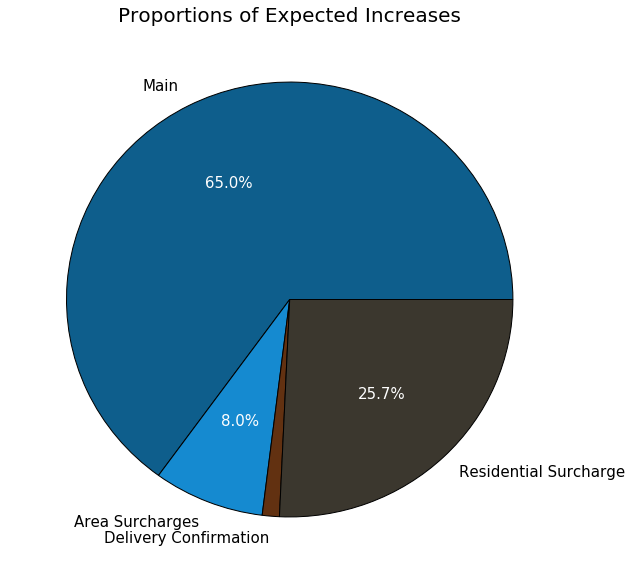

In [191]:
colors = ['#0e5e8c',
          '#158ad0',
          '#623111',
          '#3b372e',
          '#f6f6f6',]

cols = results.loc[:,:'residential surcharge increase'].columns.tolist()

for_chart = jb_conf(results).loc['mean'][cols]

def my_autopct(pct):
    return ('%.1f%%' % pct) if pct > 5 else ''

fig, ax = plt.subplots(figsize = (10,10))

ls = for_chart.index
ls2 = []
for x in ls:
    y = x.split(' ')[:-1]
    y = ' '.join(y)
    y = y.title()
    ls2.append(y)
    
wedges, labels, texts = ax.pie(for_chart,
                              labels = ls2,
                              autopct = my_autopct,
                              rotatelabels = False)

for l in labels:
    l.set_fontsize(15)
    
for t in texts:
    t.set_fontsize(15)    
    t.set_color('white')
    
for i in range(len(wedges)):
    color = colors[i]
    wedges[i].set_color(color)
    wedges[i].set_linewidth(1)
    wedges[i].set_edgecolor('black')    
    
ax.set_title('Proportions of Expected Increases', fontsize = 20)
plt.savefig(image_path + ax.get_title(), bbox_inches = 'tight')

plt.show()

# Review - Estimates vs Actual

In [3]:
# when new rates went into effect
review_date_start = '2018-12-26'

In [7]:
review = pd.read_sql(
'''
SELECT
o.orders_id,
A.ups_charge

FROM orders o

LEFT JOIN
(SELECT
orders_id,
SUM(netamount) AS ups_charge
FROM ups_billing
GROUP BY orders_id) A ON o.orders_id = A.orders_id

WHERE DATE(date_purchased) >= ' '''+ review_date_start +''' '
AND shipping_module_code = 'upsxml'
AND A.ups_charge IS NOT NULL # exclude orders for which we do not yet have ups billing data
''', db)

col_fix(review)

In [32]:
n = review['orders id'].count()
m = review['ups charge'].mean()
s = review['ups charge'].std()

alpha = 0.05
t = stats.t.ppf(1-alpha/2, n-1)

l = m - t * (s/np.sqrt(n))
u = m + t * (s/np.sqrt(n))

print('lower: ${:,.2f}\nmean: ${:,.2f}\nupper: ${:,.2f}'.format(l,m,u))

lower: $13.62
mean: $13.83
upper: $14.03


In [38]:
pd.read_sql(
'''
SELECT
DATE_FORMAT(transaction_date, '%Y-%m') AS year_and_month,
SUM(netamount) AS ups_charge
FROM ups_billing
WHERE DATE(transaction_date) BETWEEN '2018-06-01' AND '2018-11-31'
AND orders_id IN (SELECT orders_id FROM orders)
GROUP BY year_and_month
''', db)

,year_and_month,ups_charge
0,2018-06,169021.57
1,2018-07,192679.85
2,2018-08,161985.27
3,2018-09,164923.04
4,2018-10,193695.44
5,2018-11,182076.78
